In [ ]:
# Example: Linear Regression with Spark MLlib
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Initialize Spark Session
spark = SparkSession.builder.appName('MLlib Example').getOrCreate()

# Load sample data
data = [(1, 5.0, 20.0), (2, 10.0, 25.0), (3, 15.0, 30.0), (4, 20.0, 35.0)]
columns = ['ID', 'Feature', 'Target']
df = spark.createDataFrame(data, columns)

# Prepare data for modeling
assembler = VectorAssembler(inputCols=['Feature'], outputCol='Features')
df_transformed = assembler.transform(df)

# Train a linear regression model
lr = LinearRegression(featuresCol='Features', labelCol='Target')
model = lr.fit(df_transformed)

# Print model coefficients
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')

Coefficients: [0.9999999999999992]
Intercept: 15.000000000000009


In [ ]:
# Practice: Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors # Import Vectors for creating vector type

# Example dataset
# Modify data to use Vectors.dense for the feature column directly
data = [
    (1, Vectors.dense([2.0, 3.0]), 0),
    (2, Vectors.dense([1.0, 5.0]), 1),
    (3, Vectors.dense([2.5, 4.5]), 1),
    (4, Vectors.dense([3.0, 6.0]), 0)
]
columns = ['ID', 'Features', 'Label']
df = spark.createDataFrame(data, columns)

# Train logistic regression model
lr = LogisticRegression(featuresCol='Features', labelCol='Label') # Use the 'Features' column directly
model = lr.fit(df) # Fit on the df directly as 'Features' is already a vector

# Display coefficients and summary
print(f'Coefficients: {model.coefficients}')
print(f'Intercept: {model.intercept}')

Coefficients: [-12.262057929180484,4.087352266486688]
Intercept: 11.56891272665312


In [ ]:
# Practice: KMeans Clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors # Import Vectors

# Example dataset
# Convert the feature lists to VectorUDT using Vectors.dense
data = [
    (1, Vectors.dense([1.0, 1.0])),
    (2, Vectors.dense([5.0, 5.0])),
    (3, Vectors.dense([10.0, 10.0])),
    (4, Vectors.dense([15.0, 15.0]))
]
columns = ['ID', 'Features']
df = spark.createDataFrame(data, columns)

# Train KMeans clustering model
kmeans = KMeans(featuresCol='Features', k=2)
model = kmeans.fit(df)

# Show cluster centers
centers = model.clusterCenters()
print(f'Cluster Centers: {centers}')

Cluster Centers: [array([12.5, 12.5]), array([3., 3.])]


In [ ]:
spark = SparkSession.builder.appName('Spotify Classification').getOrCreate()
data = '/kaggle/datasets/spotify_data.csv'

# Load dataset
df = spark.read.csv(data, header=True, inferSchema=True)

# Tampilkan info dataset
print('Dataset Spotify (10 Teratas)')
df.show(10)

print('\nSchema Dataset')
df.printSchema()

print("\nJumlah Data (rows):", df.count())
print("Jumlah Kolom:", len(df.columns))

Dataset Spotify (10 Teratas)
+---+--------------------+--------------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+
|_c0|         artist_name|          track_name|            track_id|popularity|year|   genre|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|
+---+--------------------+--------------------+--------------------+----------+----+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+
|  0|          Jason Mraz|     I Won't Give Up|53QF56cjZA9RTuuMZ...|        68|2012|acoustic|       0.483| 0.303|  4| -10.058|   1|     0.0429|       0.694|             0.0|   0.115|  0.139|133.406|   240166.0|           3.0|
|  1|          Jason Mraz|    93 Million Miles|1s8tP3jP4GZcyHDsj...

In [ ]:
# Missing values per kolom
print('Missing Values per Kolom:')
for c in df.columns:
    missing = df.filter(col(c).isNull()).count()
    print(f"{c}: {missing}")

# Mengecek kolom duplikat
duplicate_count = df.count() - df.dropDuplicates().count()
print('\nTotal Data Duplikat:', duplicate_count)

Missing Values per Kolom:
_c0: 0
artist_name: 0
track_name: 0
track_id: 0
popularity: 0
year: 0
genre: 0
danceability: 0
energy: 0
key: 0
loudness: 0
mode: 0
speechiness: 0
acousticness: 0
instrumentalness: 0
liveness: 0
valence: 0
tempo: 0
duration_ms: 0
time_signature: 0

Total Data Duplikat: 0


In [ ]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import DoubleType

# Buat Label: Populer (>50) = 1, Tidak Populer = 0
df_lr = df.withColumn(
    "Label",
    when(col("popularity") > 50, 1).otherwise(0)
)

# Pilih fitur numerik saja
numeric_features = [
    "danceability", "energy", "loudness",
    "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo"
]

# Ubah tipe ke float
df_lr = df_lr.withColumn("popularity", col("popularity").cast(DoubleType()))
for colname in numeric_features:
    df_lr = df_lr.withColumn(colname, col(colname).cast("float"))

# VectorAssembler, membuat kolom 'Features'
assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="Features",
    handleInvalid="skip"
)

df_final = assembler.transform(df_lr).select("Features", "Label")

# Logistic Regression Model
lr = LogisticRegression(featuresCol="Features", labelCol="Label")

# Train model
model = lr.fit(df_final)

# Output Koefisien dan Intercept
print("Evaluasi Matriks Logistic Regression Model Berdasarkan Popularitas lagu")
print(f"Coefficients:\n{model.coefficients}")
print(f"Intercept:\n{model.intercept}")

Evaluasi Matriks Logistic Regression Model Berdasarkan Popularitas lagu
Coefficients:
[3.0306565500278224,-1.9623209532883237,0.10975973925860755,0.23353635085587446,-0.4299823024627963,-1.915683453682965,-0.727709082995994,-1.094630441505864,0.0019677102485972783]
Intercept:
-1.9443526694809425


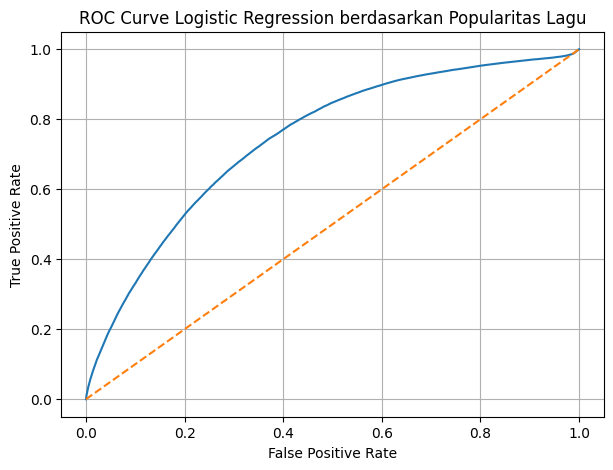

AUC: 0.7432191002310985


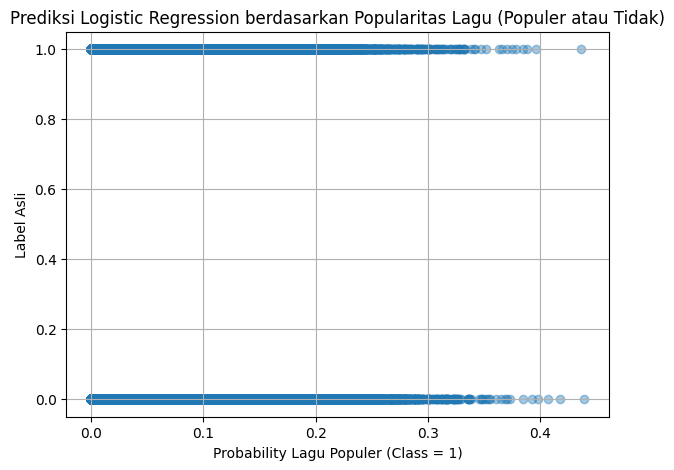

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegressionSummary
import matplotlib.pyplot as plt
import pandas as pd

# Ambil summary logistic regression
summary = model.summary

# ROC Curve
roc = summary.roc.toPandas()

plt.figure(figsize=(7,5))
plt.plot(roc['FPR'], roc['TPR'])
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Logistic Regression berdasarkan Popularitas Lagu")
plt.grid(True)
plt.show()

# AUC value
evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(model.transform(df_final))
print("AUC:", auc)

# Scatter plot hasil prediksi
pred_df = model.transform(df_final).select("Label", "probability", "prediction").toPandas()

# Ambil probability menjadi angka
pred_df['pop_prob'] = pred_df['probability'].apply(lambda x: float(x[1]))

plt.figure(figsize=(7,5))
plt.scatter(pred_df['pop_prob'], pred_df['Label'], alpha=0.4)
plt.xlabel("Probability Lagu Populer (Class = 1)")
plt.ylabel("Label Asli")
plt.title("Prediksi Logistic Regression berdasarkan Popularitas Lagu (Populer atau Tidak)")
plt.grid(True)
plt.show()

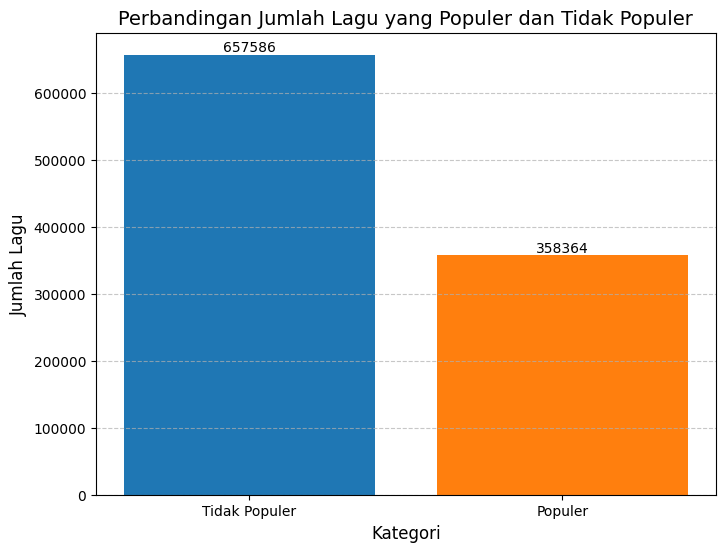

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Hitung jumlah lagu per Label
df_counts = df_final.groupBy("Label").count().orderBy("Label").toPandas()

# Map label 0 dan 1 ke nama kategori agar lebih mudah dibaca
label_map = {0: 'Tidak Populer', 1: 'Populer'}
df_counts['Category'] = df_counts['Label'].map(label_map)
df_counts = df_counts.dropna(subset=['Category'])

# Buat Bar Chart
plt.figure(figsize=(8, 6))

# Plotting
bars = plt.bar(df_counts['Category'], df_counts['count'], color=['#1f77b4', '#ff7f0e'])

# Menambahkan judul dan label
plt.title('Perbandingan Jumlah Lagu yang Populer dan Tidak Populer', fontsize=14)
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Jumlah Lagu', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan angka di atas batang
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Tampilkan plot
plt.show()

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Membuat label mood berdasarkan nilai valence dan energy
df_mood = df.withColumn(
    "Mood",
    when((col("valence") >= 0.5) & (col("energy") >= 0.6), "Happy")
    .when((col("valence") >= 0.5) & (col("energy") < 0.6), "Chill")
    .when(col("valence") < 0.5, "Sad")
    .when(col("energy") >= 0.7, "Energetic")
    .otherwise("Chill")
)

# Daftar fitur numerik yang digunakan untuk prediksi
numeric_features = ["valence", "energy", "tempo"]

# Mengubah tipe data menjadi numerik
for c in numeric_features:
    df_mood = df_mood.withColumn(c, col(c).cast("float"))

# Mengubah label mood menjadi angka
indexer = StringIndexer(inputCol="Mood", outputCol="Label")
df_mood_indexed = indexer.fit(df_mood).transform(df_mood)

# Menyatukan fitur menjadi satu vektor
assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="Features",
    handleInvalid="skip"
)

df_final = assembler.transform(df_mood_indexed).select("Features", "Label")

# Membangun model random forest untuk klasifikasi mood
rf = RandomForestClassifier(
    featuresCol="Features",
    labelCol="Label",
    numTrees=120,
    maxDepth=8,
    seed=42
)

# Melatih model
rf_model = rf.fit(df_final)

# Melakukan prediksi
predictions = rf_model.transform(df_final)

print("Evaluasi Random Forest Untuk Klasifikasi Mood Lagu")
print("\nPentingnya Tiap Fitur:")
print(rf_model.featureImportances)

print("\nJumlah Pohon Dalam Model:")
print(rf_model.getNumTrees)

# Menghitung akurasi model
evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"\nAkurasi Model: {accuracy:.4f}")

Evaluasi Random Forest Untuk Klasifikasi Mood Lagu

Pentingnya Tiap Fitur:
(3,[0,1,2],[0.733728735798818,0.2650920565539089,0.001179207647273073])

Jumlah Pohon Dalam Model:
120

Akurasi Model: 0.9830


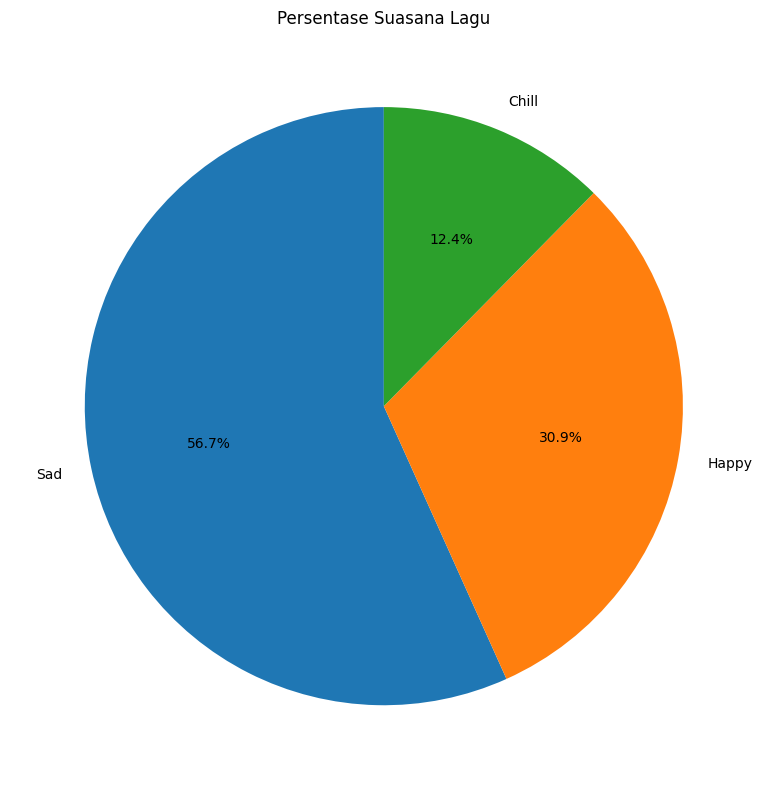

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah lagu per kategori mood
pdf_mood = (
    df_mood.groupBy("Mood")
           .count()
           .orderBy("count", ascending=False)
           .toPandas()
)

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    pdf_mood["count"],
    labels=pdf_mood["Mood"],
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Persentase Suasana Lagu")
plt.tight_layout()
plt.show()